<a href="https://www.kaggle.com/code/shomerthesec/city-persons-dataset?scriptVersionId=162657992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Preparing The Data


In [1]:
import scipy.io
from tqdm.notebook import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random
from matplotlib.pyplot import figure
import shutil
import os
import numpy as np

### Converting the Mat files to Pandas DataFrame

In [2]:
mat = scipy.io.loadmat('/kaggle/input/city-persons-annotations/anno_train.mat')
full_data_arr=[]
for img_data in tqdm(mat['anno_train_aligned'][0]):
    for instance in img_data[0][0][2]:
        full_data_arr.append([img_data[0][0][0][0],img_data[0][0][1][0],instance[0],instance[1],instance[2],instance[3],instance[4],instance[5],instance[6],instance[7],instance[8],instance[9]])

train_df=pd.DataFrame(full_data_arr,columns=['city','image_id','class_label', 'x1','y1','w','h', 'instance_id', 'x1_vis', 'y1_vis', 'w_vis', 'h_vis'])


mat = scipy.io.loadmat('/kaggle/input/city-persons-annotations/anno_val.mat')
full_data_arr=[]
for img_data in tqdm(mat['anno_val_aligned'][0]):
    for instance in img_data[0][0][2]:
        full_data_arr.append([img_data[0][0][0][0],img_data[0][0][1][0],instance[0],instance[1],instance[2],instance[3],instance[4],instance[5],instance[6],instance[7],instance[8],instance[9]])

val_df=pd.DataFrame(full_data_arr,columns=['city','image_id','class_label', 'x1','y1','w','h', 'instance_id', 'x1_vis', 'y1_vis', 'w_vis', 'h_vis'])


class_dict={0: 'ignore regions' ,
1: 'pedestrians',
2: 'riders',
3: 'sitting persons',
4: 'other persons unusual postures',
5: 'group of people'}

print(val_df['class_label'].value_counts())
print(train_df['class_label'].value_counts())




### checking if all the images are available
all_imgs=train_df['image_id'].unique()
print(len(all_imgs))
for img_path in all_imgs:
    path=img_path.split('_')[0]+'/'+img_path
    if not os.path.exists('/kaggle/input/cityscapes/Cityscape/leftImg8bit/train/'+path):
        print(path)
all_imgs=val_df['image_id'].unique()
print(len(all_imgs))
for img_path in all_imgs:
    path=img_path.split('_')[0]+'/'+img_path
    if not os.path.exists('/kaggle/input/cityscapes/Cityscape/leftImg8bit/val/'+path):
        print(path)

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

1    3157
0    1631
2     509
5     226
3     185
4      87
Name: class_label, dtype: int64
1    16526
0     6768
2     1680
5     1347
3     1032
4      417
Name: class_label, dtype: int64
2778
487


In [3]:
train_df=train_df.drop(train_df[train_df['class_label']==0].index)
val_df=val_df.drop(val_df[val_df['class_label']==0].index)

train_df['class_label']=train_df['class_label'].replace([2,3,4,5],[0,0,0,0])
val_df['class_label']=val_df['class_label'].replace([2,3,4,5],[0,0,0,0])

In [4]:
def visual(image,splitted_boxes):
    
    for box in splitted_boxes:
        c,x,y,w,h=box
        x_min=x
        x_max=x+w
        y_min=y
        y_max=y+h
        X,Y,_=image.shape

        isClosed = True

        # Blue color in BGR
        color = (255, 0, 0)

        # Line thickness of 2 px
        thickness = 5

        # Using cv2.polylines() method
        # Draw a Blue polygon with
        # thickness of 1 px
#         print((int(x_min*X), int(y_min*Y)), (int(x_max*X), int(y_max*Y)))
#         cv2.rectangle(image, (int(x_min*X), int(y_min*Y)), (int(x_max*X), int(y_max*Y)), (255,0,0), 4)
        image=cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255,0,0), 4)
        image=cv2.putText(image, class_dict[c], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0))
        
        


    return image

(1024, 2048, 3)


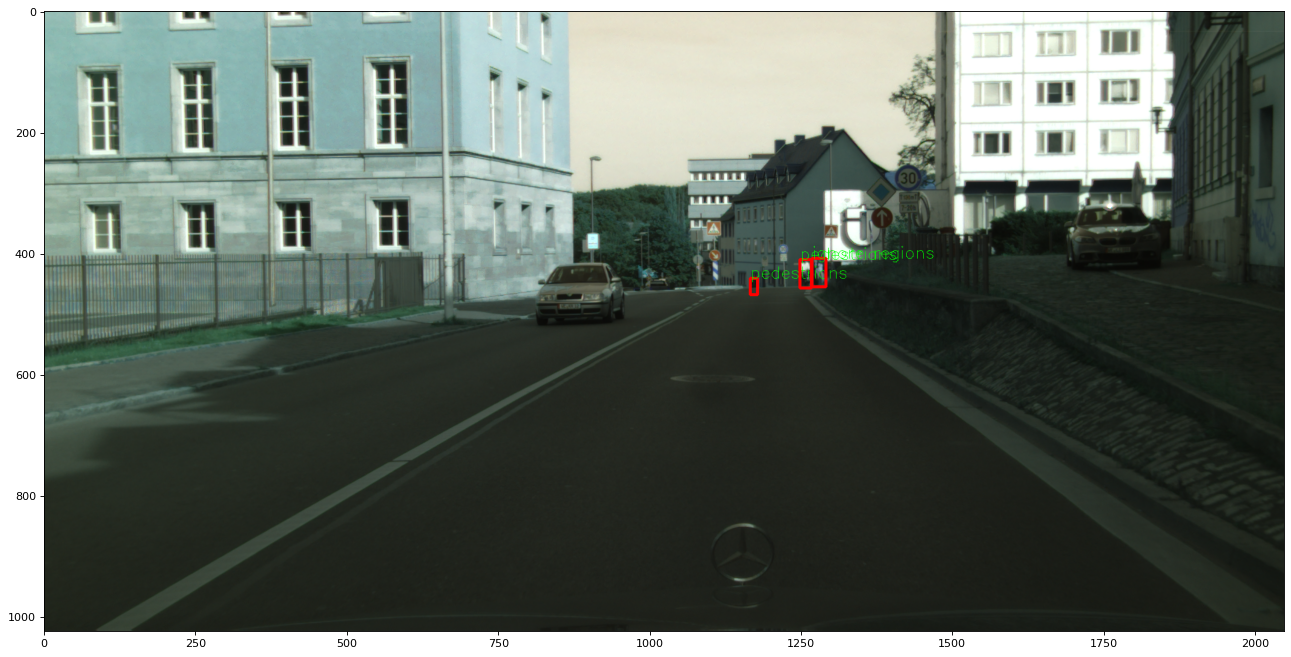

In [5]:

figure(figsize=(20, 16), dpi=80)
i=random.randint(0,2500)
all_ids=train_df['image_id'].unique()
c_box=train_df[train_df['image_id']==all_ids[i]][['class_label','x1','y1','w','h']].values
img_path='/kaggle/input/cityscapes/Cityscape/leftImg8bit/train/'+all_ids[i].split('_')[0]+'/'+all_ids[i]
img=cv2.imread(img_path)
print(img.shape)
plt.imshow(visual(img,c_box))


In [6]:
import os

os.makedirs('./yolo_dir/train/images')
os.makedirs('./yolo_dir/train/labels')
os.makedirs('./yolo_dir/valid/images')
os.makedirs('./yolo_dir/valid/labels')

In [7]:


# train_ids=list(train_df['image_id'].unique())
# val_ids=list(val_df['img_id'].unique())


def prepare_dir(from_dir,to_dir_img,to_dir_labels,df):
    id_list=list(df['image_id'].unique())
    for idd in tqdm(id_list):
        shutil.copy(from_dir+idd.split('_')[0]+'/'+idd, to_dir_img+idd)


    if to_dir_labels is not None:
        for idd in tqdm(id_list):
            types=df[df['image_id']==idd]['class_label'].values
            cords=df[df['image_id']==idd][['x1','y1','w','h']].values
            cords_new=np.zeros(cords.shape)
             
            cords_new[:,0]=(cords[:,0]+cords[:,2]/2)/2048
            cords_new[:,1]=(cords[:,1]+cords[:,3]/2)/1024
            cords_new[:,2]=cords[:,2]/2048
            cords_new[:,3]=cords[:,3]/1024


            all_cord_list=''
            for typ, cord in zip(types,cords_new):
                trial=[typ]+list(cord)
                prv=''
                for s in [str(x) for x in trial]:
                    prv=prv+' '+s

                all_cord_list=all_cord_list+prv+' '


            with open('{}{}.txt'.format(to_dir_labels,idd.split('.')[0]), 'w') as f:
                f.writelines(all_cord_list)

from_dir='/kaggle/input/cityscapes/Cityscape/leftImg8bit/train/'
to_dir_img='/kaggle/working/yolo_dir/train/images/'
to_dir_labels='/kaggle/working/yolo_dir/train/labels/'
df=train_df
prepare_dir(from_dir,to_dir_img,to_dir_labels,df)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [8]:
from_dir='/kaggle/input/cityscapes/Cityscape/leftImg8bit/val/'
to_dir_img='/kaggle/working/yolo_dir/valid/images/'
to_dir_labels='/kaggle/working/yolo_dir/valid/labels/'
df=val_df
prepare_dir(from_dir,to_dir_img,to_dir_labels,df)

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

Image shape: (1024, 2048, 3)
Image height=1024 and width=2048
 1 0.5146484375 0.45166015625 0.009765625 0.0458984375  1 0.5029296875 0.453125 0.0087890625 0.044921875 


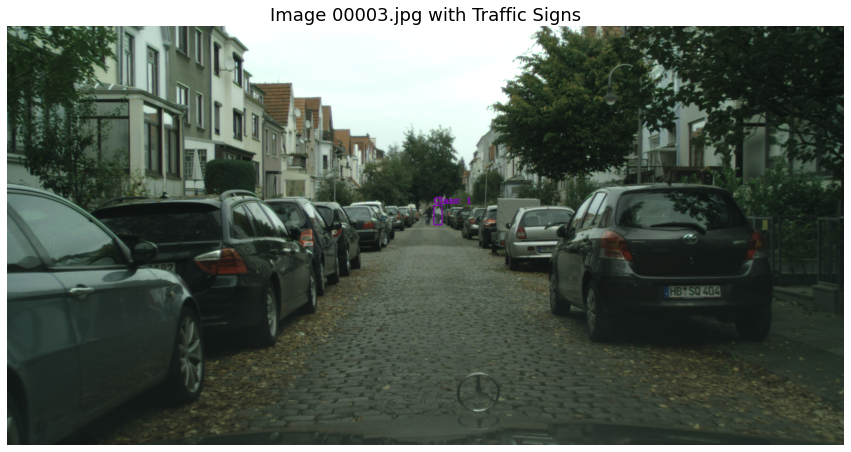

In [9]:
#### checking the annotations
idd=list(train_df['image_id'].unique())[random.randint(0,2000)]

image_BGR = cv2.imread('/kaggle/working/yolo_dir/train/images/{}'.format(idd))

# Showing image shape
print('Image shape:', image_BGR.shape)  # tuple of (800, 1360, 3)

# Getting spatial dimension of input image
h, w = image_BGR.shape[:2]  # Slicing from tuple only first two elements

# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))  # 800 1360


# Reading annotation txt file that has bounding boxes coordinates in YOLO format
with open('/kaggle/working/yolo_dir/train/labels/{}'.format(idd.split('.')[0]+'.txt')) as f:
    # Preparing list for annotation of BB (bounding boxes)
    lst = []
    for line in f:
        lst += [line.rstrip()]
        print(line)

# Going through all BB
for i in range(len(lst)):
    # Getting current bounding box coordinates, its width and height
    bb_current = lst[i].split()
    x_center, y_center = int(float(bb_current[1]) * w), int(float(bb_current[2]) * h)
    box_width, box_height = int(float(bb_current[3]) * w), int(float(bb_current[4]) * h)
    
    # Now, from YOLO data format, we can get top left corner coordinates
    # that are x_min and y_min
    x_min = int(x_center - (box_width / 2))
    y_min = int(y_center - (box_height / 2))

    # Drawing bounding box on the original image
    cv2.rectangle(image_BGR, (x_min, y_min), (x_min + box_width, y_min + box_height), [172 , 10, 127], 2)

    # Preparing text with label and confidence for current bounding box
    class_current = 'Class: {}'.format(bb_current[0])

    # Putting text with label and confidence on the original image
    cv2.putText(image_BGR, class_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_COMPLEX, 0.7, [172 , 10, 127], 2)
    
    

%matplotlib inline

# Plotting this example
# Setting default size of the plot
plt.rcParams['figure.figsize'] = (15, 15)

# Initializing the plot
fig = plt.figure()

plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Image 00003.jpg with Traffic Signs', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('example.png')
plt.close()

In [10]:
cat yolo_dir/train/labels/aachen_000000_000019_leftImg8bit.txt

 0 0.440673828125 0.46044921875 0.01025390625 0.0517578125  0 0.4482421875 0.45947265625 0.0166015625 0.0537109375  0 0.9111328125 0.4775390625 0.021484375 0.103515625 

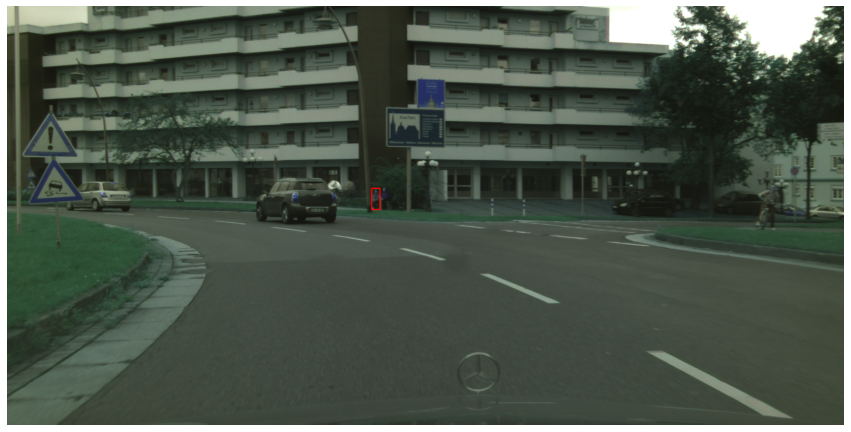

In [11]:
path= 'yolo_dir/train/images/aachen_000000_000019_leftImg8bit.png'
image= cv2.imread(path)
og_h , og_w , _ = image.shape 

with open(path.replace('images','labels').replace('.png','.txt')  ,'r' ) as f:
    data=f.read().split() 
   
c , x , y , w , h = data[:5]
x = float(x)    
y = float(y)
w = float(w)
h= float(h)
x= int( x * og_w  )
y= int(  y * og_h )
width= int( w * og_w  )//2
height = int( h * og_h )//2


# Draw rectangle on the image
color = (255, 0, 0)  # Define color as blue (in RGB)
thickness = 2  # Thickness of the rectangle border
cv2.rectangle(image, (x-width, y-height), (x + width, y + height), color, thickness)

# Visualize the image with the rectangle
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

# Preparing the yolo-v8 model

In [12]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.145 🚀 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5432.3/8062.4 GB disk)


In [13]:
!mkdir datasets 
!cp -r yolo_dir/ datasets

In [14]:
!mv datasets/yolo_dir/* datasets/
!rm -r datasets/yolo_dir

!mkdir -p datasets/images/train/
!mkdir -p datasets/labels/train/
!mkdir -p datasets/images/valid/
!mkdir -p datasets/labels/valid/

!mv datasets/train/images/* datasets/images/train/
!mv datasets/train/labels/* datasets/labels/train/
!mv datasets/valid/images/* datasets/images/valid/
!mv datasets/valid/labels/* datasets/labels/valid/

!rm -r datasets/valid
!rm -r datasets/train

# Augmenting data 

In [15]:
# !pip install tensorpack # if you don't have tensorpack install it
from glob import glob 
from matplotlib import pyplot as plt 
from tqdm import tqdm 
import cv2 
from tensorpack.dataflow.imgaug import (
    RandomOrderAug,BrightnessScale, Saturation, Brightness,  Hue,
    Contrast,    GaussianBlur,    GaussianNoise,    Rotation,    JpegNoise,
    RandomResize,  MinMaxNormalize, Grayscale, Lighting , Shift , MeanVarianceNormalize,
    Flip , SaltPepperNoise
)
import random
import os 
import numpy as np 
import shutil

def return_regular_augmentors():
    regular_augmentors = [
        
        GaussianBlur(random.randint(2,4)),
        Brightness(random.randint(2,10),clip=True),
        GaussianNoise(random.randint(2,4)),
        JpegNoise(quality_range=(10,50)),
        Hue(range=(0,20), rgb=True),
        RandomResize( (0.3 , 1.5) , (0.3 , 1.5) ),
        MinMaxNormalize(),
        SaltPepperNoise(np.random.random()*5/100 , np.random.random()*5/100 ),
        RandomOrderAug(
            [BrightnessScale((0.3, 1.4), clip=True),
            Contrast((0.3, 1.4), clip=True),
            Saturation( random.random() , rgb=True, clip = True),
            GaussianBlur(random.randint(2,4)),
            GaussianNoise(random.randint(2,4)),
            ]),
        RandomOrderAug(
            [Contrast((0.5, 1.2), clip=True),
            Hue(range=(0,20), rgb=True),
            ]),
        RandomOrderAug(
            [Contrast((0.5, 1.2), clip=True),
            SaltPepperNoise(np.random.random()*1/100 , np.random.random()*1/100 ),  
            ]),
        RandomOrderAug(
            [Brightness(random.randint(3,15),clip=True),
            GaussianBlur(random.randint(2,4)),
            JpegNoise(quality_range=(10,50)),
            Hue(range=(0,20), rgb=True)
            ]) ,
        RandomOrderAug(
            [
            GaussianBlur(random.randint(2,4)),
            SaltPepperNoise(np.random.random()*1/100 , np.random.random()*1/100 ),  
            ]),
    ]
    return regular_augmentors

def augment_image(img  , aug ):
    transform = aug.get_transform(img)
    augmented_img = transform.apply_image(img)
    return augmented_img 

train_imgs= 'datasets/images/train/'
train_labels = 'datasets/labels/train/'
val_imgs= 'datasets//images/valid/'
val_labels = 'datasets/labels/valid'

list_train_imgs = os.listdir( train_imgs )
list_train_labels= os.listdir( train_labels )
list_val_imgs= os.listdir( val_imgs )
list_val_labels= os.listdir( val_labels )


In [16]:
len(list_train_imgs) == len(list_train_labels)
print( len( list_train_labels ) )

len(list_val_imgs) == len(list_val_labels)
print(len( list_val_imgs ))

2500
441


In [17]:
list_val_imgs[0]

'lindau_000011_000019_leftImg8bit.png'

In [19]:
for image_name in tqdm( list_train_imgs ) :
    
    label_name = image_name.replace('png', 'txt')
    
    path_of_label = train_labels + label_name
    path_of_image = train_imgs + image_name 
    
    img= cv2.imread(path_of_image) 
    
    for idx, augmentation_method in enumerate(return_regular_augmentors()):
        augmented_img = augment_image( img.copy() , augmentation_method  ) 
               
        if np.random.random() < 0.2:        
            aug_imgs = val_imgs
            aug_labels = val_labels
        else:
            aug_imgs = train_imgs
            aug_labels = train_labels
        
        cv2.imwrite( aug_imgs + f'aug_{idx}_' + image_name , augmented_img )
        shutil.copy( path_of_label , aug_labels + f'aug_{idx}_' + label_name )
                            
    # break

  7%|▋         | 174/2500 [09:13<2:03:16,  3.18s/it]


KeyboardInterrupt: 

In [85]:
data= [
r'path: ../datasets/ # dataset root dir ',
r"train: images/train # train images (relative to 'path') 1281167 images ",
r"val: images/valid # val images (relative to 'path') 50000 images ",
r'test: # test images (optional) ',
r'# Classes ',
r'names: ',
r'  0: pedestrian ',
r'  1: anything'
]

with open('data.yaml','w') as f :
    for line in data:
        f.write(line) , f.write('\n')

In [87]:
# Train YOLOv8n on COCO8 for 3 epochs
!yolo train model=yolov8n.pt data=data.yaml epochs=200 imgsz=640 format=onnx batch=32 augment=True optimize=True patience=10

New https://pypi.org/project/ultralytics/8.1.11 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145 🚀 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=200, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False,

In [77]:
!yolo export model=/kaggle/working/runs/detect/train3/weights/best.pt format=onnx

Ultralytics YOLOv8.0.145 🚀 Python-3.7.12 torch-1.11.0 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients

PyTorch: starting from '/kaggle/working/runs/detect/train4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)

ONNX: starting export with onnx 1.12.0 opset 14...
ONNX: export success ✅ 2.9s, saved as '/kaggle/working/runs/detect/train4/weights/best.onnx' (11.7 MB)

Export complete (4.5s)
Results saved to /kaggle/working/runs/detect/train4/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/detect/train4/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=/kaggle/working/runs/detect/train4/weights/best.onnx imgsz=640 data=None 
Visualize:       https://netron.app


In [83]:
import shutil
shutil.make_archive( '/kaggle/working/run_result', 'zip', '/kaggle/working/runs/detect/train3/')


'/kaggle/working/run_result.zip'